# Represent the empirical affinity matrix as a graph

### Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import networkx as nx

### Set globals for plotting

In [3]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Load all x all matrix
column 8 is wrong

In [4]:
allxall = np.load("allxall.npy")
# fix column 8 for now
allxall[:,7] = (allxall[:,7] * 0.10)
# add axis labels
xlabels = ["BW3_A_sm", "BW3_B_sm","BW5_A_sm","BW5_B_sm","IL8_A_sm","IL8_B_sm","IL9_A_sm","IL9_B_sm","IL14_A_sm","IL14_B_sm"]
ylabels = ["BW3_B_lg", "BW3_A_lg","BW5_B_lg","BW5_A_lg","IL8_B_lg","IL8_A_lg","IL9_B_lg","IL9_A_lg","IL14_B_lg","IL14_A_lg"]

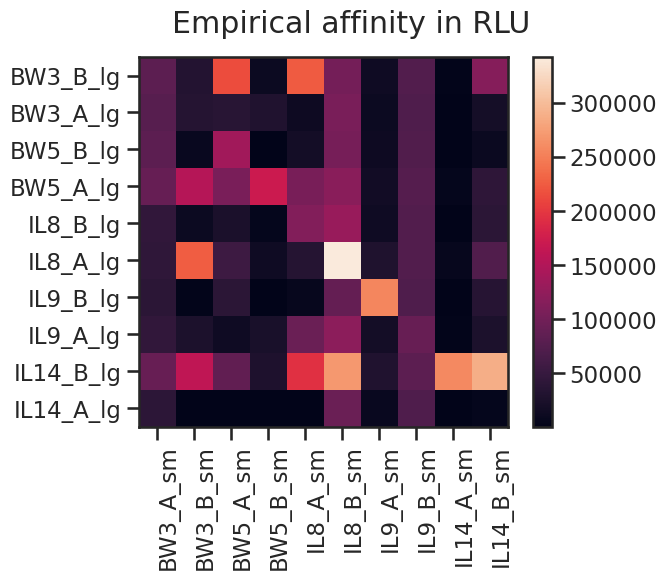

In [5]:
def plot_mat(matrix, xlabels, ylabels, title):
    fig, ax = plt.subplots()
    # We want to show all ticks...
    ax.set_xticks(np.arange(matrix.shape[0]))
    ax.set_yticks(np.arange(matrix.shape[1]))
    # ... and label them with the respective list entries
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    mat = ax.imshow(matrix)
    fig.suptitle(title)
    fig.colorbar(mappable=mat)
    plt.show()
    return


plot_mat(allxall, xlabels, ylabels, "Empirical affinity in RLU")

### Plot distribution of data

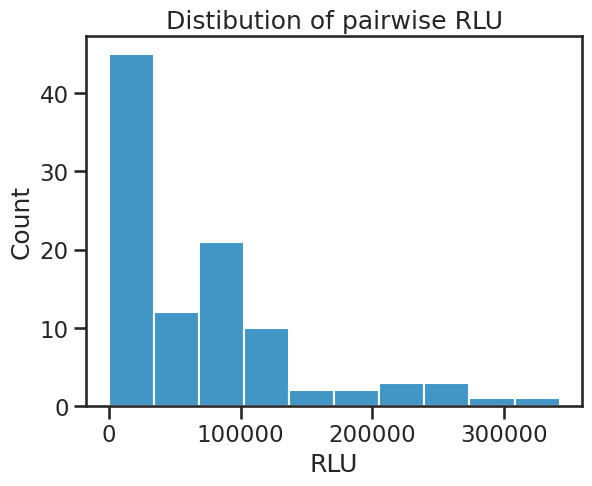

In [6]:
flat = allxall.flatten()
_ = sns.histplot(flat, bins="auto")
plt.title("Distibution of pairwise RLU")
plt.xlabel("RLU")
plt.show()

### Threshold and discretize interactions
Probably can threshold around 3.3e4

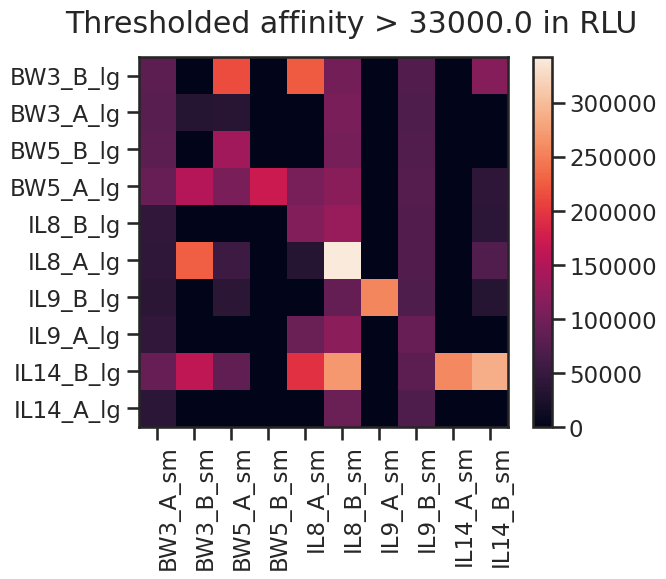

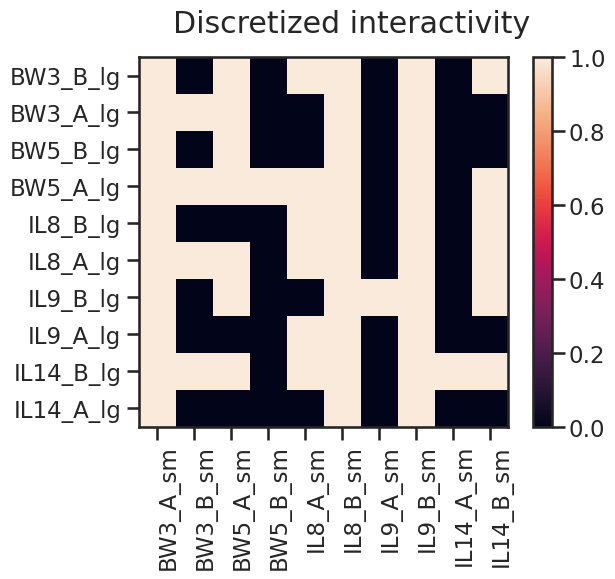

In [7]:
# if less than 3.3e4, 0
cutoff = 3.3e4
thresholded = allxall.copy()
thresholded[thresholded < cutoff] = 0
plot_mat(thresholded, xlabels, ylabels, f"Thresholded affinity > {cutoff} in RLU")

# discretize, if > 0, 1
discrete = thresholded.copy()
discrete[discrete > 0] = 1
plot_mat(discrete, xlabels, ylabels, f"Discretized interactivity")

### Build a graph by looping over the discretized matrix
also save as a pickle and plot

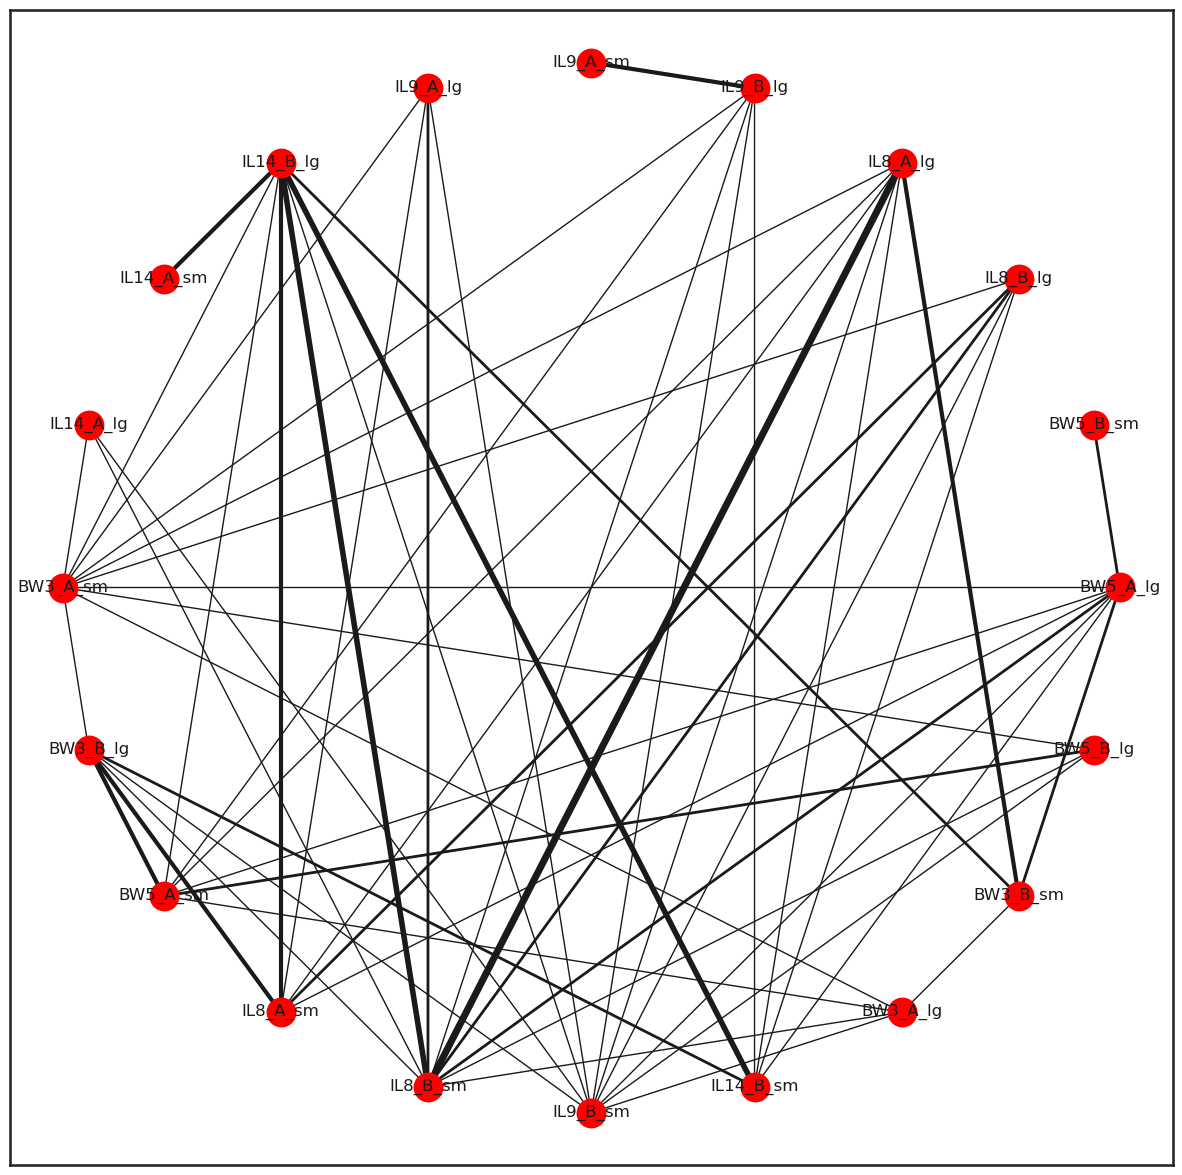

In [15]:
plt.close()
G = nx.Graph()

edges = []
for row, ylabel in enumerate(ylabels):
    for col, xlabel in enumerate(xlabels):
        if bool(discrete[row,col]):
            G.add_node(xlabel, chain=xlabel.split("_")[1], bit=xlabel.split("_")[-1])
            G.add_node(ylabel, chain=ylabel.split("_")[1], bit=ylabel.split("_")[-1])
            edges.append((xlabel, ylabel, {"weight": thresholded[row,col]}))
        else:
            pass

        
G.add_edges_from(edges)
pos = nx.shell_layout(G)
weights = nx.get_edge_attributes(G, "weight")
nodelist = G.nodes()

# bin and discretize weights for plotting
bins = np.linspace(min(weights.values()), max(weights.values()), 5)
weights = dict(zip(weights.keys(), np.digitize(list(weights.values()), bins=bins)))
# options for drawing
options = {"node_color": "red", "node_size": 400, "alpha": 1.0}
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       **options,
                      )
nx.draw_networkx_edges(G,pos,
                       edgelist = weights.keys(),
                       width=list(weights.values()),
                      )
nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                       )

nx.write_gpickle(G, "empirical.pickle")

plt.show()        

### What a mess. Still, it seems correct... 

In [10]:
nx.get_node_attributes(G, "bit")

{'BW3_A_sm': 'sm',
 'BW3_B_lg': 'lg',
 'BW5_A_sm': 'sm',
 'IL8_A_sm': 'sm',
 'IL8_B_sm': 'sm',
 'IL9_B_sm': 'sm',
 'IL14_B_sm': 'sm',
 'BW3_A_lg': 'lg',
 'BW3_B_sm': 'sm',
 'BW5_B_lg': 'lg',
 'BW5_A_lg': 'lg',
 'BW5_B_sm': 'sm',
 'IL8_B_lg': 'lg',
 'IL8_A_lg': 'lg',
 'IL9_B_lg': 'lg',
 'IL9_A_sm': 'sm',
 'IL9_A_lg': 'lg',
 'IL14_B_lg': 'lg',
 'IL14_A_sm': 'sm',
 'IL14_A_lg': 'lg'}

In [11]:
nx.get_node_attributes(G, "chain")

{'BW3_A_sm': 'A',
 'BW3_B_lg': 'B',
 'BW5_A_sm': 'A',
 'IL8_A_sm': 'A',
 'IL8_B_sm': 'B',
 'IL9_B_sm': 'B',
 'IL14_B_sm': 'B',
 'BW3_A_lg': 'A',
 'BW3_B_sm': 'B',
 'BW5_B_lg': 'B',
 'BW5_A_lg': 'A',
 'BW5_B_sm': 'B',
 'IL8_B_lg': 'B',
 'IL8_A_lg': 'A',
 'IL9_B_lg': 'B',
 'IL9_A_sm': 'A',
 'IL9_A_lg': 'A',
 'IL14_B_lg': 'B',
 'IL14_A_sm': 'A',
 'IL14_A_lg': 'A'}